<h4>Install prophet + plotly for interactive plotting (interactive plots are laggy)

In [1]:
!pip install prophet


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install plotly


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL

f2021 = "../IT-NO_2021_hourly.csv"
f2022 = "../IT-NO_2022_hourly.csv"
f2023 = "../IT-NO_2023_hourly.csv"

dataset1 = pd.read_csv(f2021)
dataset2 = pd.read_csv(f2022)
dataset3 = pd.read_csv(f2023)

c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data concatenation of carbon intensity:
dataset_CI = pd.concat([dataset1, dataset2, dataset3], axis=0)

dataset_CI['Datetime (UTC)'] = pd.to_datetime(dataset_CI['Datetime (UTC)'])
dataset_CI.rename(columns={'Datetime (UTC)': 'timestamp'}, inplace=True) # Column renaming
dataset_CI.set_index('timestamp', inplace=True)

dataset_CI.drop(columns=['Country', 'Zone Name', 'Zone Id', 'Data Source', 'Data Estimated', 'Data Estimation Method', 'Low Carbon Percentage', 'Renewable Percentage'], inplace=True)
dataset_CI['LCA+direct'] = dataset_CI['Carbon Intensity gCO₂eq/kWh (LCA)'] + dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)']
dataset_CI

,Carbon Intensity gCO₂eq/kWh (direct),Carbon Intensity gCO₂eq/kWh (LCA),LCA+direct
timestamp,,,
2021-01-01 00:00:00,303.29,389.74,693.03
2021-01-01 01:00:00,303.45,387.76,691.21
2021-01-01 02:00:00,295.04,377.86,672.90
2021-01-01 03:00:00,295.56,380.36,675.92
2021-01-01 04:00:00,308.06,394.66,702.72
...,...,...,...
2023-12-31 19:00:00,260.51,333.72,594.23
2023-12-31 20:00:00,265.88,342.93,608.81
2023-12-31 21:00:00,250.60,324.02,574.62


In [3]:
dataset_CI.drop(columns=['Carbon Intensity gCO₂eq/kWh (direct)', 'Carbon Intensity gCO₂eq/kWh (LCA)'], inplace=True)
dataset_CI

,LCA+direct
timestamp,
2021-01-01 00:00:00,693.03
2021-01-01 01:00:00,691.21
2021-01-01 02:00:00,672.90
2021-01-01 03:00:00,675.92
2021-01-01 04:00:00,702.72
...,...
2023-12-31 19:00:00,594.23
2023-12-31 20:00:00,608.81
2023-12-31 21:00:00,574.62


Testing prophet on LCA+direct datapoints. documentation: https://facebook.github.io/prophet/docs/quick_start.html#python-api
 

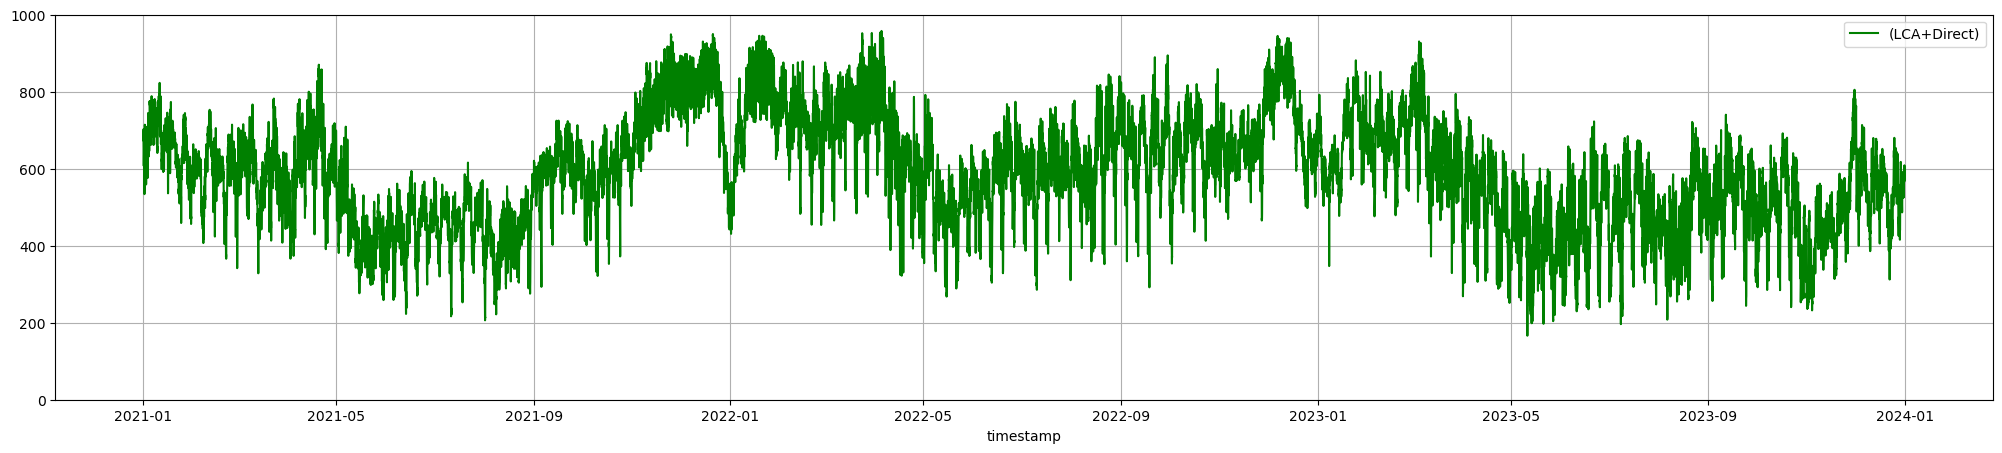

In [4]:
# Plotting and comparison od the different CI values
x = dataset_CI.index
y = dataset_CI['LCA+direct']

# Create subplots with shared X-axis
fig, ax1 = plt.subplots(1, 1, figsize=(25, 5), sharex=True)

# Plot data on each subplot

ax1.grid(True)
ax1.plot(x, y, 'g', label='(LCA+Direct)')
ax1.set_ylim(0, 1000)
ax1.set_xlabel('timestamp')

# Add legends

ax1.legend()

# Show the plot
plt.show()


Preparing the dataframe as required by the prophet documentation:

In [5]:
dataset_CI

,LCA+direct
timestamp,
2021-01-01 00:00:00,693.03
2021-01-01 01:00:00,691.21
2021-01-01 02:00:00,672.90
2021-01-01 03:00:00,675.92
2021-01-01 04:00:00,702.72
...,...
2023-12-31 19:00:00,594.23
2023-12-31 20:00:00,608.81
2023-12-31 21:00:00,574.62


In [6]:
dataset_CI_fix = dataset_CI.reset_index()
dataset_CI_fix

,timestamp,LCA+direct
0,2021-01-01 00:00:00,693.03
1,2021-01-01 01:00:00,691.21
2,2021-01-01 02:00:00,672.90
3,2021-01-01 03:00:00,675.92
4,2021-01-01 04:00:00,702.72
...,...,...
26275,2023-12-31 19:00:00,594.23
26276,2023-12-31 20:00:00,608.81
26277,2023-12-31 21:00:00,574.62
26278,2023-12-31 22:00:00,597.98


In [7]:
dataset_CI_fix.rename(columns={'timestamp':'ds', 'LCA+direct':'y' }, inplace=True)
dataset_CI_fix

,ds,y
0,2021-01-01 00:00:00,693.03
1,2021-01-01 01:00:00,691.21
2,2021-01-01 02:00:00,672.90
3,2021-01-01 03:00:00,675.92
4,2021-01-01 04:00:00,702.72
...,...,...
26275,2023-12-31 19:00:00,594.23
26276,2023-12-31 20:00:00,608.81
26277,2023-12-31 21:00:00,574.62
26278,2023-12-31 22:00:00,597.98


Creating another dataset with data only before 2023-01, to predict 2023 and see the performance and compare

In [8]:
dataset_half = dataset_CI_fix[(dataset_CI_fix['ds'] < '2023-01')]

In [9]:
dataset_half

,ds,y
0,2021-01-01 00:00:00,693.03
1,2021-01-01 01:00:00,691.21
2,2021-01-01 02:00:00,672.90
3,2021-01-01 03:00:00,675.92
4,2021-01-01 04:00:00,702.72
...,...,...
17515,2022-12-31 19:00:00,743.33
17516,2022-12-31 20:00:00,733.81
17517,2022-12-31 21:00:00,742.13
17518,2022-12-31 22:00:00,739.83


Performing prediction with Prophet:

10:26:00 - cmdstanpy - INFO - Chain [1] start processing
10:26:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


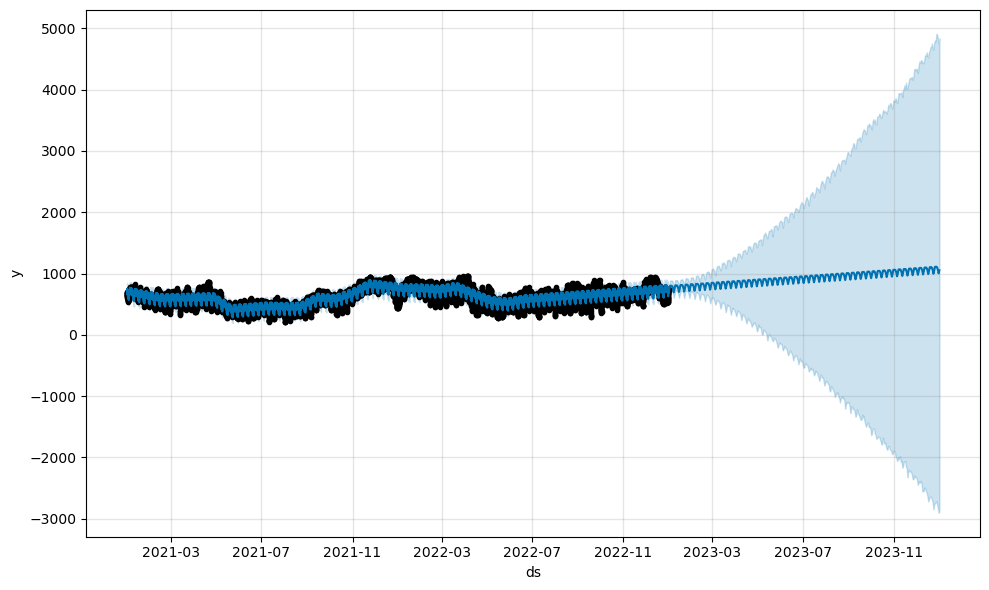

In [10]:
m_noparams = Prophet()
m_noparams.fit(dataset_half)

future = m_noparams.make_future_dataframe(periods=365)
future.tail()

forecast_noparams = m_noparams.predict(future)
forecast_noparams[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m_noparams.plot(forecast_noparams)

Trying to adjust parameters to consider seasonalities:

10:26:16 - cmdstanpy - INFO - Chain [1] start processing
10:26:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


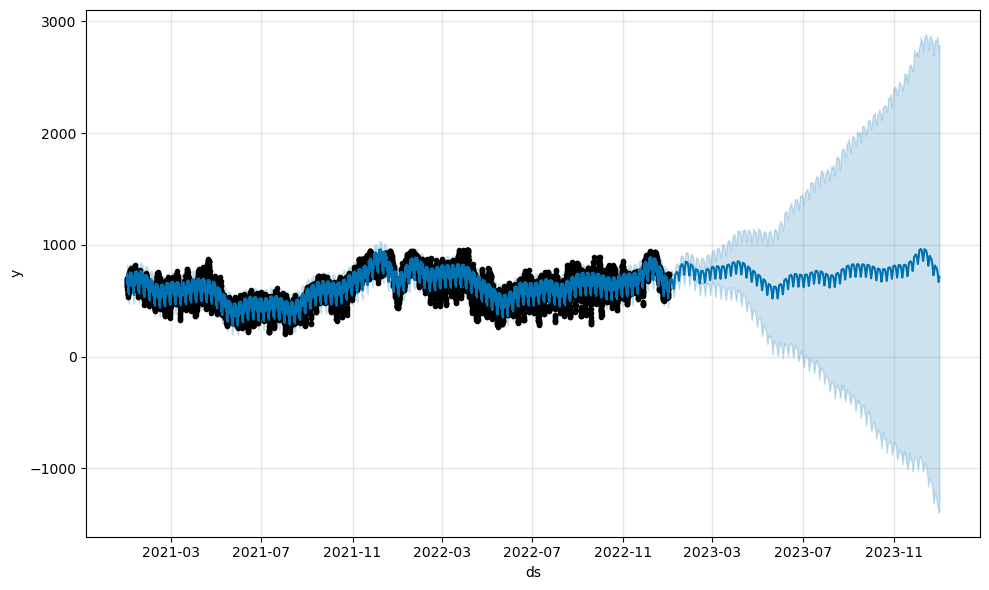

In [11]:
m = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True) # forcing to consider seasonality
m.fit(dataset_half)

future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:395: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:399: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

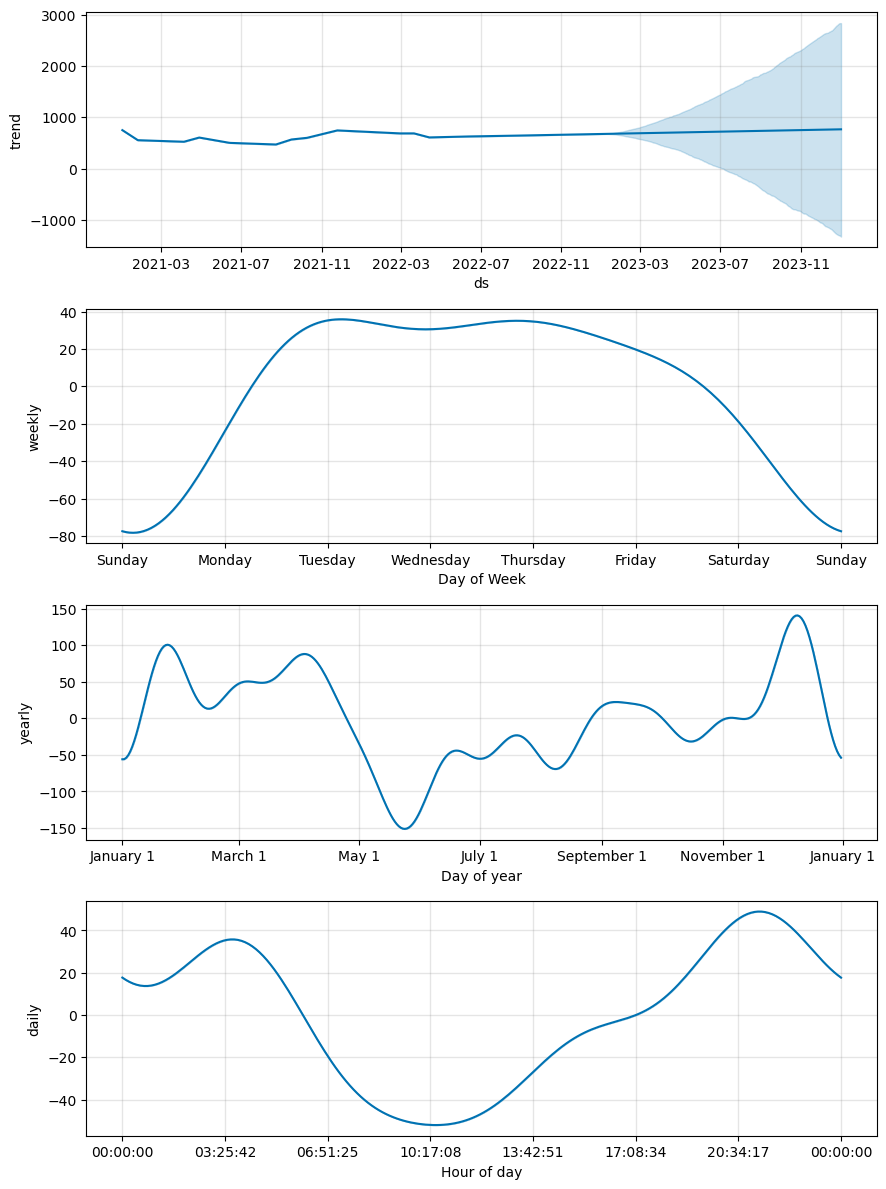

In [12]:
fig2 = m.plot_components(forecast)
plt.savefig('../PLOTS/CI_prophet.png', dpi=300) # Code to export the plot as an image

Now, looks better! Comparing with real data:

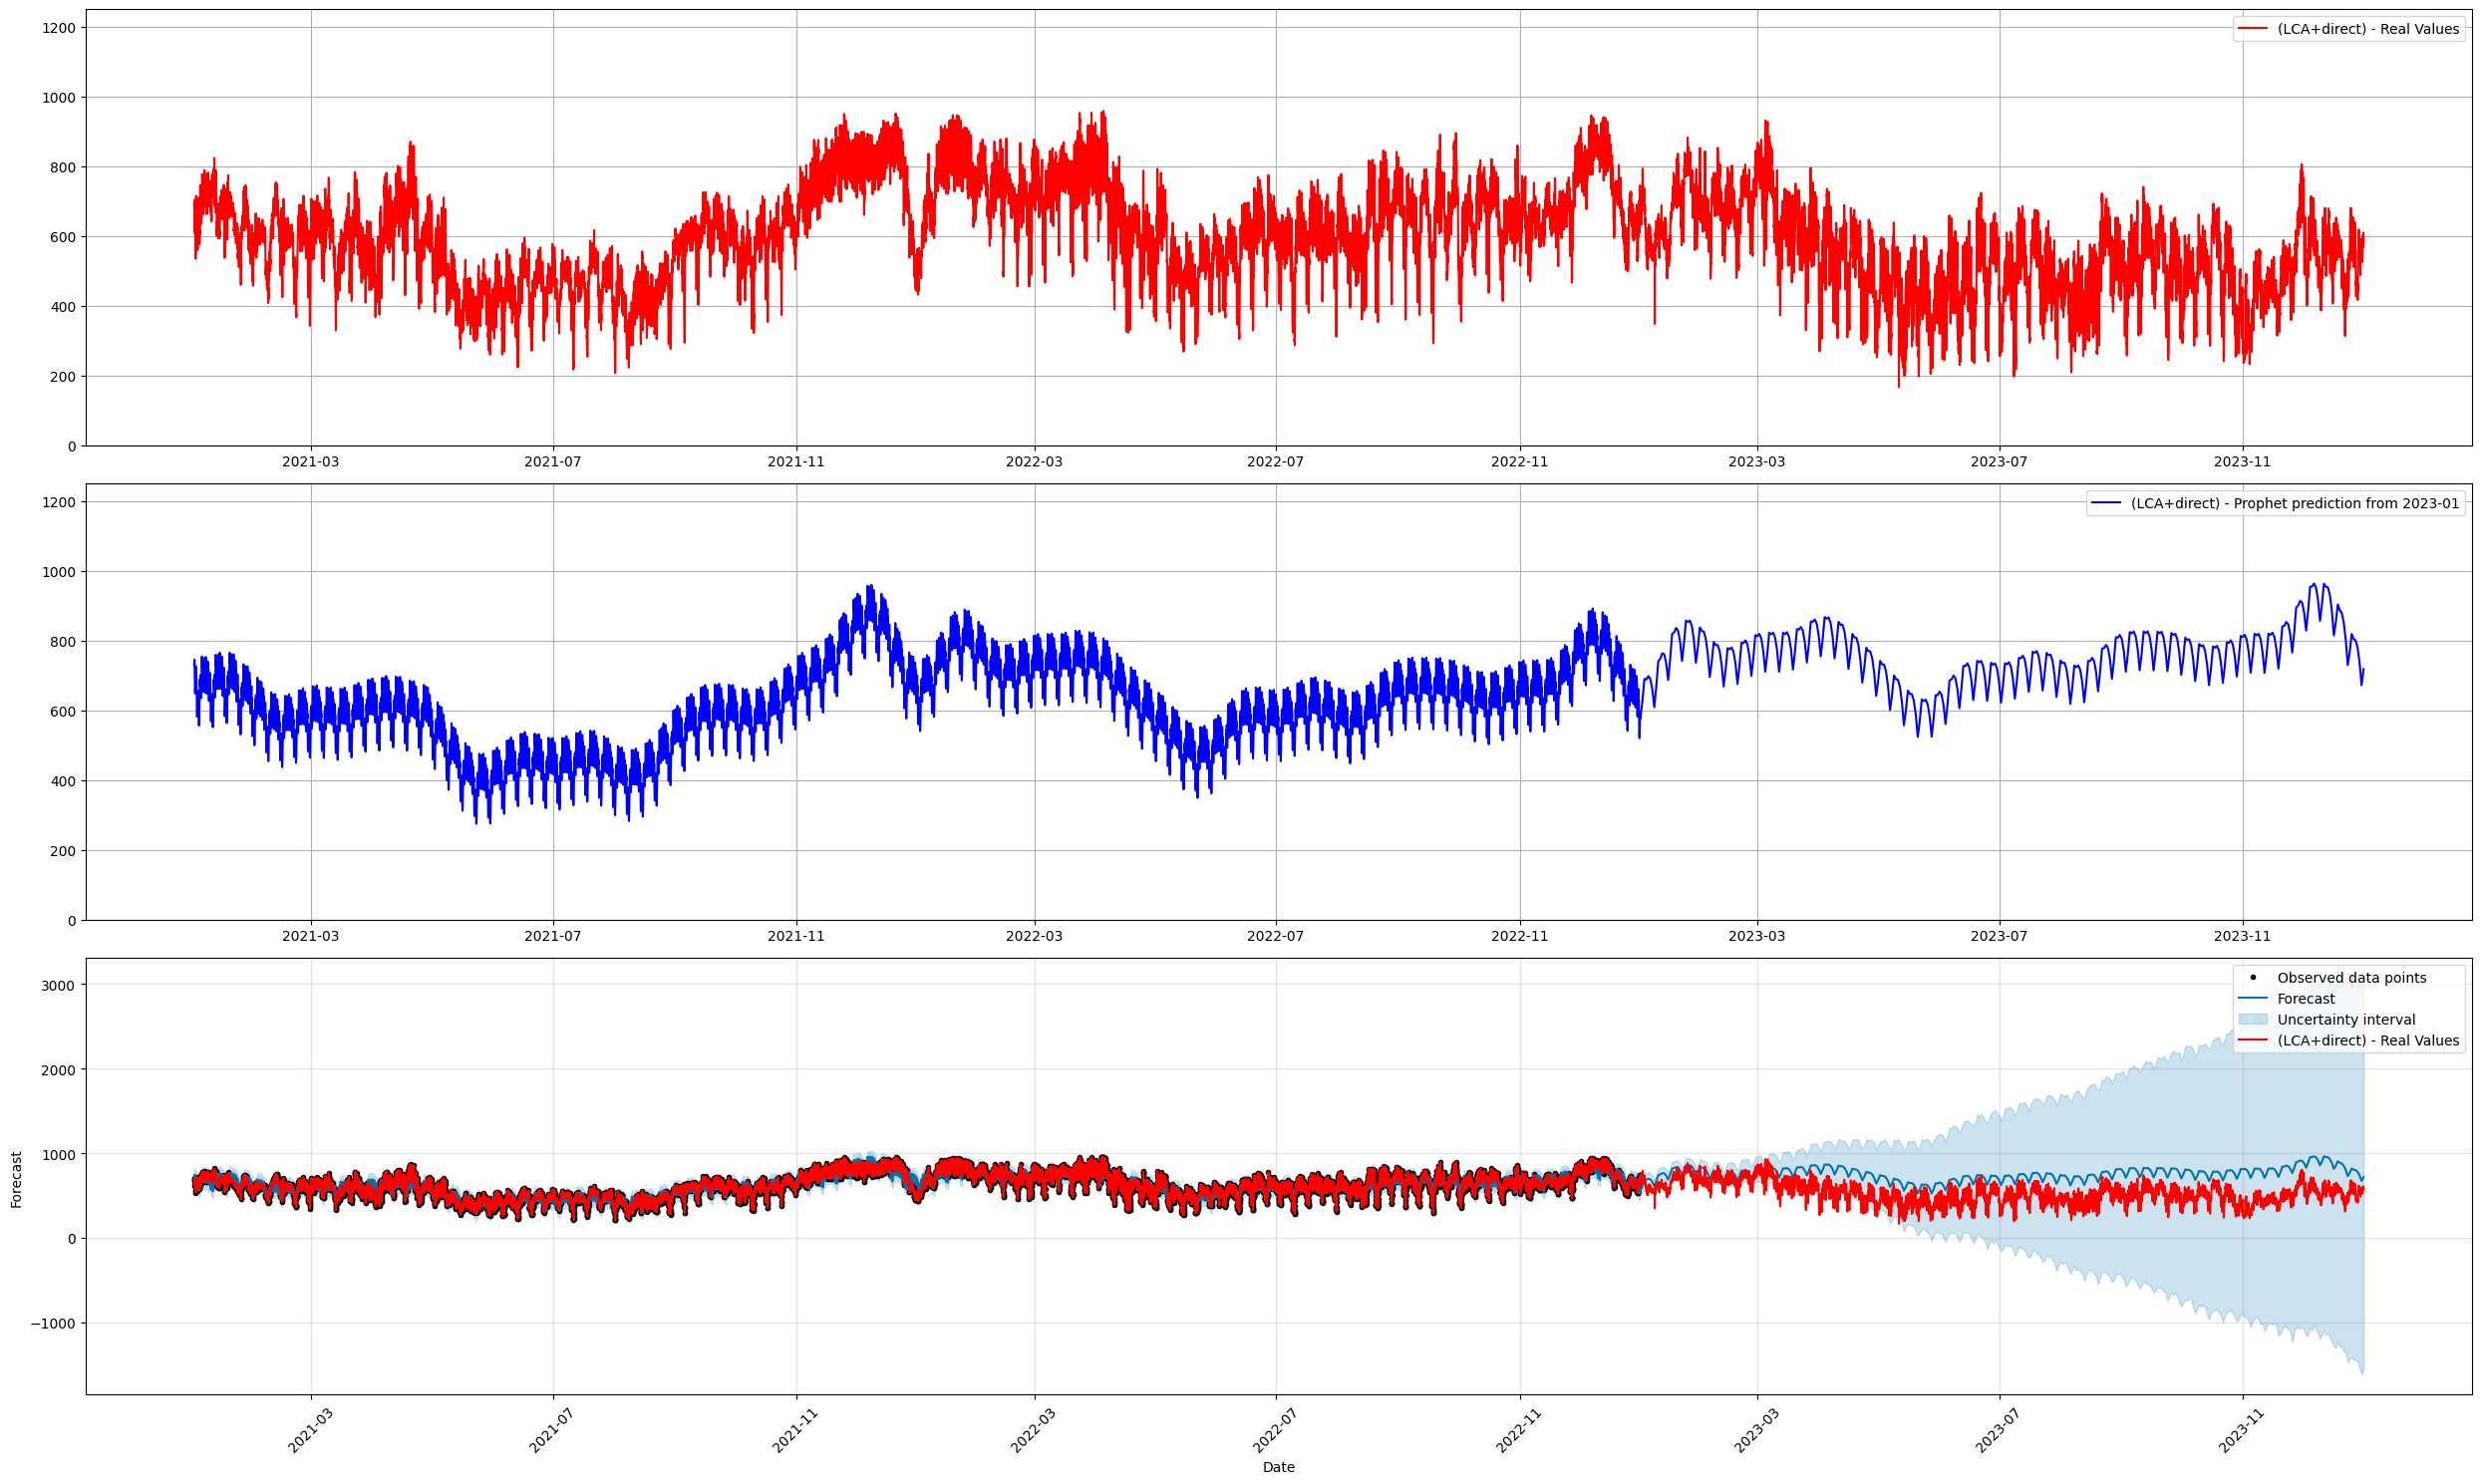

In [16]:
# datapoints:
x1 = dataset_CI.index
y1 = dataset_CI['LCA+direct']
x2 = forecast['ds']
y2 = forecast['yhat']

fig = plt.figure(figsize=(25, 15))  # Adjust the figure size as needed

# Create the first subplot
ax1 = fig.add_subplot(3, 1, 1)  # This will be the first subplot (3 rows, 1 column, first plot)
ax1.grid(True)
ax1.plot(x1, y1, 'red', label = '(LCA+direct) - Real Values')
ax1.set_ylim(0, 1250)

# Create the second subplot
ax2 = fig.add_subplot(3, 1, 2, sharex=ax1)  # This will be the second subplot
ax2.grid(True)
ax2.plot(x2, y2, 'blue', label = '(LCA+direct) - Prophet prediction from 2023-01')
ax2.set_ylim(0, 1250)

# Create the third subplot for Prophet's plot
ax3 = fig.add_subplot(3, 1, 3, sharex=ax1)  # This will be the third subplot
fig1 = m.plot(forecast, ax=ax3)  # Plot the forecast on the third subplot

ax3.plot(x1, y1, 'red', label = '(LCA+direct) - Real Values')

ax3.set_xlabel('Date')  # Set the x-axis label
ax3.set_ylabel('Forecast')  # Set the y-axis label
ax3.tick_params(axis='x', rotation=45)  # Optional: Rotate x-axis labels for better readability

ax1.legend()
ax2.legend()
ax3.legend()

plt.tight_layout()  # Adjust the layout so that plots do not overlap
plt.show()  # Display the figure

<span style="color:red;">We need to zoom the area of comparison between prediction and real data to better visualize the gap and also we need to insert the error of the prediction in the plots</span>

<span style="color:red;">I also would like to create the .plot_components for the Carbon Footprint dataset</span>